# Table of Contents
* [detections](#detections)


In [1]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload

from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import functools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

import copy
import os
import json
from tqdm import tqdm as tqdm

from IPython.display import Image
import PIL.Image as pil
import random
import cv2
import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light default
#%base16_mplrc dark solarized
plt.rcParams['grid.linewidth'] = 0
plt.rcParams['figure.figsize'] = (16.0, 10.0)

from anigen_tools.dataset import FlintstonesDataset
from anigen_tools.mturk import unpickle_this, pickle_this
from anigen_tools.trajectory_viz import filter_chars, filter_description
from anigen_tools.trajectory_viz import avg_video_appearance
from anigen_tools.trajectory_viz import draw_trajectory_set
from anigen_tools.trajectory_viz import vid_filter

In [2]:
plt.rcParams['patch.force_edgecolor'] = True
plt.rcParams['patch.linewidth'] = 1

plt.rc('font',**{'family':'serif','serif':['Times']})
# plt.rc('font', family='serif')
# plt.rc('font',**{'family':'serif','serif':['Computer Modern Roman']})

plt.rc('text', usetex=True)

In [3]:
dataset = unpickle_this('../build_dataset/complete_ds_checkpoint_v2p8_cleaned.pkl')

In [4]:
def get_vid(video_id, dataset=dataset):
    return [vid for vid in dataset if vid.gid() == video_id][0]

def get_entitity(eid, dataset=dataset):
    vid = get_vid_from_eid(eid)
    video = get_vid(vid, dataset)
    all_vid_ents = video.data()['characters'] + video.data()['objects']
    return [ent for ent in all_vid_ents if ent.gid() == eid][0]

def make_standard_fig(fig_plt, fig_labels=None, save = False, outfile='fig.pdf', main_color=None, label_color = '0.25'):
    if fig_labels:
        if 'fig_title' in fig_labels:
            plt.title(fig_labels['fig_title'], fontsize=35, verticalalignment='bottom', color=label_color)
        if 'y_label' in fig_labels:
            plt.ylabel(fig_labels['y_label'], fontsize=35, labelpad=10, color=label_color)
        if 'x_label' in fig_labels:
            plt.xlabel(fig_labels['x_label'], fontsize=30, labelpad=10, color=label_color)
    plt.tick_params(axis='x', which='major', labelsize=28)
    plt.tick_params(axis='y', which='major', labelsize=23)
    if save:
        plt.savefig(outfile, bbox_inches='tight')

# detections

In [14]:
from anigen_tools.hybrid_segmentation import get_ent_tracking
from anigen_tools.hybrid_segmentation import get_vid_frame_data
from anigen_tools.bboxes import comp_boxes_iou
from anigen_tools.interpolation import get_vid_from_eid

In [85]:
len(dataset)

26160

In [86]:
test_vid = dataset[101]
test_ent = test_vid.data()['characters'][0]

In [632]:
test_ent_track = get_ent_tracking(test_ent)

In [634]:
test_ent_track.shape

(75, 4)

In [88]:
comp_boxes_iou(test_ent_track[0], test_ent_track[-1])

0.92247539436429826

In [40]:
under_thresh = iou_w_prev_frame[iou_w_prev_frame < 0.9]

In [ ]:
def compare_flm_frames(ent):
    fr, mr, lr = np.array(ent.rect())
    fmc = comp_boxes_iou(fr, mr)
    return fmc

In [490]:
test_ent.gid()

's_01_e_07_shot_015774_015848_char_0'

In [492]:
get_vid('s_01_e_07_shot_015774_015848').display_gif()

In [486]:
compare_flm_frames(test_ent)

0.70764569879614125

In [ ]:
def detect_ent_movement(ent):
    test_ent_track = get_ent_tracking(ent)
    iou_w_prev_frame = np.array([comp_boxes_iou(test_ent_track[fn], test_ent_track[fn + 1]) for fn in range(0, test_ent_track.shape[0] -1)])
    return np.mean(iou_w_prev_frame)

In [571]:
test_ent = get_enitity('s_01_e_07_shot_000143_000217_dish_0_12')

In [572]:
detect_ent_movement(test_ent)

0.957477252216827

In [91]:
character_avg_ious = {}
for vid in dataset:
    for vent in vid.data()['characters']:
        try:
            eious = detect_ent_movement(vent)
            character_avg_ious[vent.gid()] = eious
        except FileNotFoundError:
            print(vent.gid())

/Users/schwenk/wrk/animation_gan/analyze_ds/anigen_tools/bboxes.py:43: RuntimeWarning: invalid value encountered in int_scalars
  iou = intersection / (b1_area + b2_area - intersection)
/Users/schwenk/wrk/animation_gan/analyze_ds/anigen_tools/bboxes.py:43: RuntimeWarning: invalid value encountered in long_scalars
  iou = intersection / (b1_area + b2_area - intersection)


In [92]:
object_avg_ious = {}
for vid in tqdm(dataset):
    for vent in vid.data()['objects']:
        try:
            eious = detect_ent_movement(vent)
            object_avg_ious[vent.gid()] = eious
        except FileNotFoundError:
            pass

  0%|          | 0/26160 [00:00<?, ?it/s]/Users/schwenk/wrk/animation_gan/analyze_ds/anigen_tools/bboxes.py:43: RuntimeWarning: invalid value encountered in int_scalars
  iou = intersection / (b1_area + b2_area - intersection)
  1%|▏         | 382/26160 [00:01<01:08, 374.53it/s]/Users/schwenk/wrk/animation_gan/analyze_ds/anigen_tools/bboxes.py:43: RuntimeWarning: invalid value encountered in long_scalars
  iou = intersection / (b1_area + b2_area - intersection)
100%|██████████| 26160/26160 [00:37<00:00, 688.85it/s]


In [573]:
all_char_ious = pd.Series(character_avg_ious)
all_obj_ious = pd.Series(object_avg_ious)

In [574]:
all_char_ious.mean()

0.98201909112353736

In [575]:
all_obj_ious.mean()

0.97099282052057823

In [576]:
cleaned_acious = all_char_ious.fillna(0)

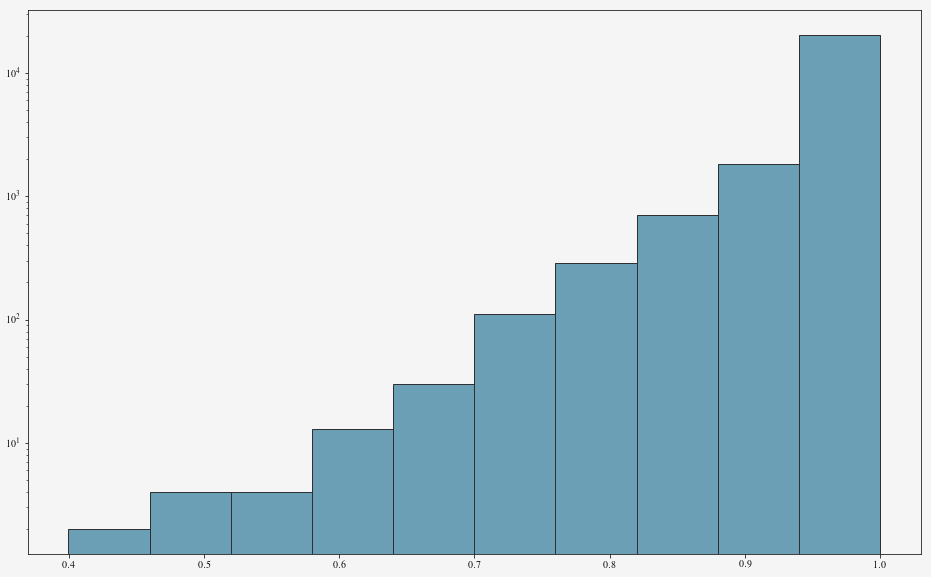

In [577]:
_ = all_obj_ious.hist(bins=10, log=True)

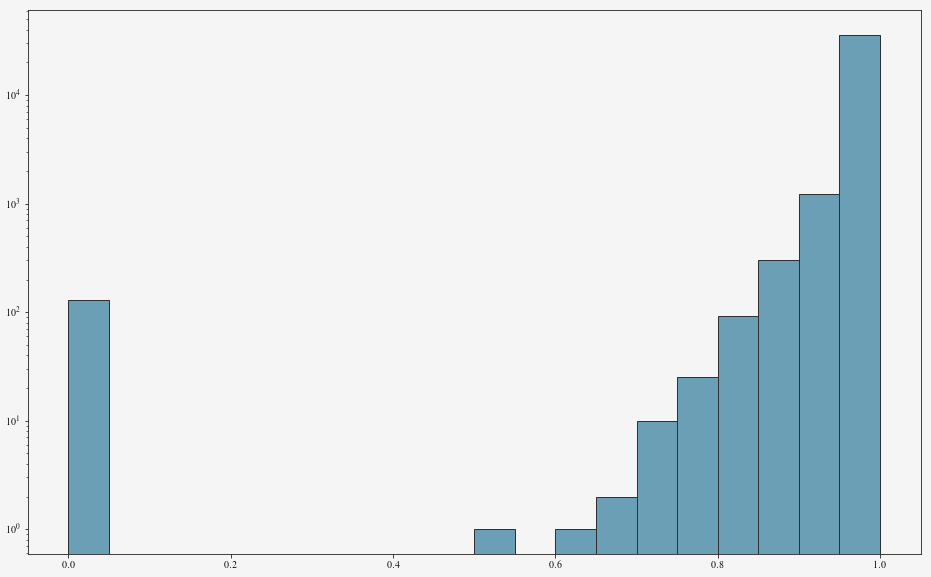

In [580]:
_ = cleaned_acious.hist(bins=20, log=True)

In [579]:
cleaned_acious.mean()

0.9786273304007217

In [120]:
's_01_e_01_shot_021703_021777_wheel_0_12'.split('_')[:7]

['s', '01', 'e', '01', 'shot', '021703', '021777']

In [593]:
movers_thresh = 0.96

In [698]:
movers_df = pd.DataFrame(all_char_ious[(all_char_ious <= movers_thresh)])
movers_df['eid'] = movers_df.index
movers_df['vid'] = movers_df['eid'].apply(get_vid_from_eid)

In [699]:
movers_df.shape

(2491, 3)

In [700]:
nonmovers_df = pd.DataFrame(all_char_ious[(all_char_ious > movers_thresh)])
nonmovers_df['eid'] = nonmovers_df.index
nonmovers_df['vid'] = nonmovers_df['eid'].apply(get_vid_from_eid)

In [697]:
nonmovers_df.shape

(35018, 3)

In [705]:
row_n = random.randint(0, movers_df.shape[0])
movers_df.iloc[row_n]

0                                 0.923363
eid    s_03_e_26_shot_024748_024822_char_0
vid           s_03_e_26_shot_024748_024822
Name: s_03_e_26_shot_024748_024822_char_0, dtype: object

In [706]:
vid_to_viz = movers_df['vid'][row_n]
vid = get_vid(vid_to_viz)
vid.display_gif()

In [718]:
row_n = random.randint(0, nonmovers_df.shape[0])
teid = nonmovers_df.iloc[row_n]['eid']
nonmovers_df.iloc[row_n]

0                                  0.99195
eid    s_05_e_15_shot_014597_014671_char_1
vid           s_05_e_15_shot_014597_014671
Name: s_05_e_15_shot_014597_014671_char_1, dtype: object

In [719]:
vid_to_viz = nonmovers_df['vid'][row_n]
vid = get_vid(vid_to_viz)
vid.display_gif()

In [715]:
from anigen_tools.bboxes import nms
from anigen_tools.bboxes import prep_boxes_v2

In [ ]:
def select_ent_static_rect(eid):
    ent = get_enitity(eid)
    s_boxes, dupe_boxes, all_boxes = nms(ent.rect(), 0.5, prep_boxes_v2)
    sorted_boxes = sorted(s_boxes, key=lambda x: x['votes'], reverse=True)
    best_box = sorted_boxes[0]
    if best_box['votes'] > 1:
        return best_box['box']
    else:
        return None

In [540]:
select_ent_static_rect('s_01_e_10_shot_026176_026250_beret_0_16')

array([127, 173, 200, 219])

In [446]:
test_obj = vid.data()['objects'][0]

In [447]:
test_rects = test_obj.rect()

In [202]:
s_boxes, dupe_boxes, all_boxes = nms(test_rects, 0.5, prep_boxes_v2)

In [236]:
select_ent_static_rect(teid)

array([ 74, 302, 211, 405])

In [726]:
nonmovers_df_sample = nonmovers_df

In [730]:
%%time
nonmovers_df_sample['rects'] = nonmovers_df_sample['eid'].apply(select_ent_static_rect)

CPU times: user 9min 23s, sys: 1.68 s, total: 9min 24s
Wall time: 9min 26s


In [619]:
# %%time
# movers_df['rects'] = movers_df['eid'].apply(select_ent_static_rect)

CPU times: user 1min 17s, sys: 263 ms, total: 1min 18s
Wall time: 1min 18s


In [731]:
noncon_rects_df = nonmovers_df_sample[nonmovers_df_sample['rects'].isna()]

In [732]:
con_rects_df = nonmovers_df_sample[~nonmovers_df_sample['rects'].isna()]

In [671]:
trow= con_rects_df.iloc[0]

In [672]:
write_stable_tracking(trow)

In [683]:
trajectories_dir = 'trajectories'
tracking_dir = 'tracking_stabilized'

def write_stable_tracking(row, n_frames=75):
    eid = row['eid']
    rect = row['rects']
    outfile = os.path.join(trajectories_dir, tracking_dir, eid + '.npy')
    rect_arr = np.expand_dims(rect, 0).repeat(n_frames, axis=0)
    np.save(outfile, rect_arr)

In [736]:
_ = con_rects_df.apply(lambda x: write_stable_tracking(x), axis=1)

In [668]:
con_rects_df.iloc[0]

array([400, 187, 647, 411])

In [ ]:
write_stable_tracking(test_ent)

In [636]:
srect = test_tects[0]

In [649]:
tar = np.array(srect)

array([[154,   4, 448, 400]])

In [611]:
noncon_rects_df.shape

(3, 4)

In [612]:
noncon_rects_df.head()

,0,eid,vid,rects
s_04_e_18_shot_009111_009185_clothes_0_4,0.964538,s_04_e_18_shot_009111_009185_clothes_0_4,s_04_e_18_shot_009111_009185,None
s_05_e_03_shot_029861_029935_shower_0_5,0.960238,s_05_e_03_shot_029861_029935_shower_0_5,s_05_e_03_shot_029861_029935,None
s_06_e_11_shot_041688_041762_costume_1_14,0.964352,s_06_e_11_shot_041688_041762_costume_1_14,s_06_e_11_shot_041688_041762,None


In [621]:
movers_df.head()

,0,eid,vid,rects
s_01_e_01_shot_002640_002714_newspaper_0_4,0.949345,s_01_e_01_shot_002640_002714_newspaper_0_4,s_01_e_01_shot_002640_002714,"[115, 27, 242, 198]"
s_01_e_01_shot_002640_002714_newspapers_0_11,0.955636,s_01_e_01_shot_002640_002714_newspapers_0_11,s_01_e_01_shot_002640_002714,"[126, 23, 304, 340]"
s_01_e_01_shot_002640_002714_street_0_17,0.937737,s_01_e_01_shot_002640_002714_street_0_17,s_01_e_01_shot_002640_002714,"[39, 330, 608, 436]"
s_01_e_01_shot_003278_003352_slate_0_10,0.957929,s_01_e_01_shot_003278_003352_slate_0_10,s_01_e_01_shot_003278_003352,"[341, 169, 513, 370]"
s_01_e_01_shot_003762_003836_golf club_0_9,0.959663,s_01_e_01_shot_003762_003836_golf club_0_9,s_01_e_01_shot_003762_003836,"[253, 104, 314, 290]"


In [687]:
nonmovers_df.sort_values(0).head()

,0,eid,vid,rects
s_02_e_11_shot_009141_009215_hat_0_11,0.960010,s_02_e_11_shot_009141_009215_hat_0_11,s_02_e_11_shot_009141_009215,"[244, 75, 489, 215]"
"s_06_e_09_shot_041976_042050_crown,_0_11",0.960030,"s_06_e_09_shot_041976_042050_crown,_0_11",s_06_e_09_shot_041976_042050,"[385, 25, 511, 150]"
s_02_e_31_shot_035772_035846_mirror_1_9,0.960041,s_02_e_31_shot_035772_035846_mirror_1_9,s_02_e_31_shot_035772_035846,"[392, 77, 469, 248]"
s_06_e_16_shot_033088_033162_chairs_0_6,0.960041,s_06_e_16_shot_033088_033162_chairs_0_6,s_06_e_16_shot_033088_033162,"[65, 275, 166, 436]"
s_04_e_21_shot_021395_021469_cap_2_9,0.960077,s_04_e_21_shot_021395_021469_cap_2_9,s_04_e_21_shot_021395_021469,"[108, 52, 235, 123]"


In [6]:
with open('/Users/schwenk/wrk/animation_gan/build_dataset/ws_sample_ids.txt') as f:
    sample_ids = set([l.strip() for l in f.readlines()])

In [7]:
sample_ds = [v for v in dataset if v.gid() in sample_ids]

In [750]:
pickle_this(sample_ds, 'sample_ds_100.pkl')

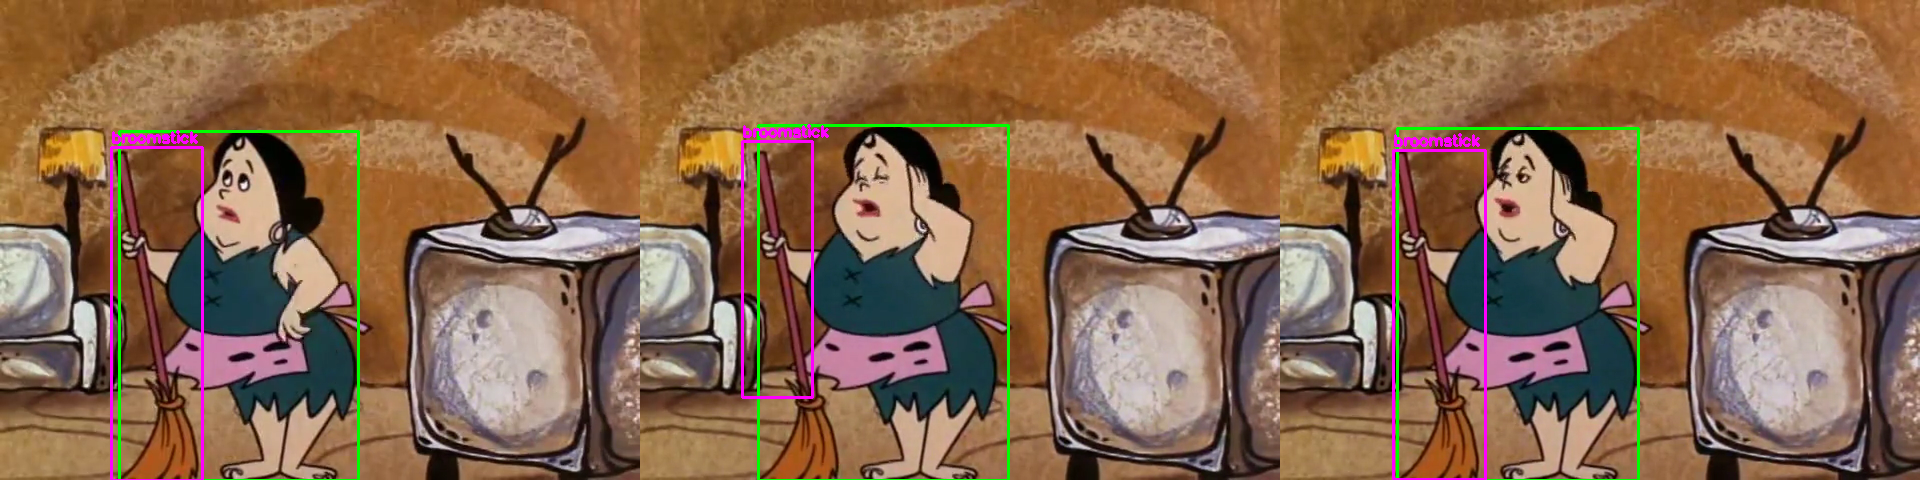

In [629]:
sv = get_vid('s_03_e_17_shot_020064_020138')
sv.display_bounding_boxes()

In [616]:
te = get_enitity('s_01_e_10_shot_026176_026250_beret_0_16')

In [530]:
select_ent_static_rect('s_01_e_10_shot_026176_026250_beret_0_16')

In [527]:
te.rect()

[[112, 171, 182, 233], [121, 165, 206, 222], [127, 173, 200, 219]]

In [528]:
nms(te.rect()[0:-1], 0.5, prep_boxes_v2)

([{'area': 4340,
   'box': array([112, 171, 182, 233]),
   'idx': 0,
   'label': 'entity',
   'votes': 2}],
 [{'area': 4845,
   'box': array([121, 165, 206, 222]),
   'duplicate_of': 0,
   'idx': 1,
   'label': 'entity'}],
 [{'area': 4845,
   'box': array([121, 165, 206, 222]),
   'duplicate_of': 0,
   'idx': 1,
   'label': 'entity'},
  {'area': 4340,
   'box': array([112, 171, 182, 233]),
   'idx': 0,
   'label': 'entity',
   'votes': 2}])

In [525]:
from anigen_tools.tracking import draw_video_tracking

In [746]:
for i in range(10):
    row_n = random.randint(0, nonmovers_df.shape[0])

    sv = get_vid(nonmovers_df.iloc[row_n]['vid'])

    draw_video_tracking(sv, False)

In [909]:
's_03_e_06_shot_013310_013384' in nonmovers_df.

SyntaxError: invalid syntax (<ipython-input-909-98c3683291be>, line 1)

In [911]:
draw_video_tracking(get_vid('s_03_e_06_shot_013310_013384'), False)

# run segmentation tests

In [8]:
from anigen_tools.hybrid_segmentation import draw_segmentation
from anigen_tools.hybrid_segmentation import get_vid_frame_data
from anigen_tools.hybrid_segmentation import draw_video_segmentations
from anigen_tools.hybrid_segmentation import gen_single_segmentation

In [9]:
from anigen_tools.segmentation_params import *

s_03_e_06_shot_013310_013384_char_0

In [10]:
def apply_mask(img, mask):
    return pil.fromarray(img * np.tile(np.expand_dims(mask, 2), [1, 1, 3]))

def convert_to_rgb(bin_img):
    return pil.fromarray(np.tile(np.expand_dims(bin_img * 255, 2), [1, 1, 3]))

In [71]:
segm_problem_video = 's_01_e_08_shot_003729_003803'
test_vid = get_vid(segm_problem_video)

test_arr_img = np.load(os.path.join(trajectories_dir, frame_arr_dir, test_vid.gid() + '.npy'))
test_frame = test_arr_img[40]
test_char = test_vid.data()['characters'][0]

In [74]:
char_segm = np.load(os.path.join(trajectories_dir, segmentation_dir, test_char.gid() + '_segm.npy.npz'))['arr_0']

In [75]:
char_segm.shape

(75, 128, 128)

In [86]:
ent_area = char_segm.sum(axis=1).sum(axis=1)

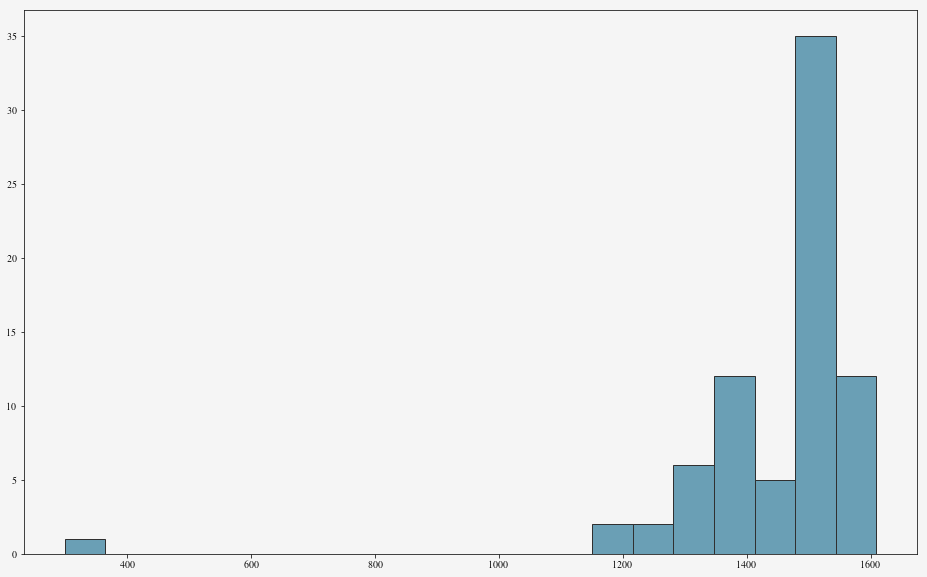

In [90]:
_ = pd.Series(ent_area).hist(bins=20)

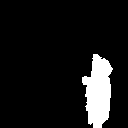

In [77]:
convert_to_rgb(char_segm[40])

In [80]:
img_area = np.product((128, 128))

In [84]:
total_area.mean()

1448.9066666666668

In [15]:
# draw_video_tracking(test_vid, False)

In [16]:
test_vid.display_gif()

1000


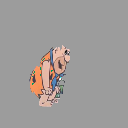

In [32]:
single_seg = gen_single_segmentation(test_vid, test_char, 40)
single_seg

In [19]:
# convert_to_rgb(single_seg)

In [943]:
dilation = cv2.dilate(char_segm, kernel, iterations = 2)

In [944]:
struct_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(8,8))
res = cv2.morphologyEx(char_segm, cv2.MORPH_OPEN, struct_kernel)

In [991]:
kernel = np.ones((3,4),np.uint8)

In [992]:
closed = cv2.morphologyEx(char_segm, cv2.MORPH_CLOSE, kernel)

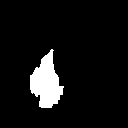

In [994]:
convert_to_rgb(closed[60])

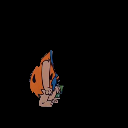

In [1001]:
pil.fromarray(get_vid_frame_data(segm_problem_video)[40] * np.tile(np.expand_dims(char_segm[40], 2), [1, 1, 3]))

In [996]:
draw_video_segmentations(test_vid)

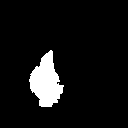

In [997]:
convert_to_rgb(char_segm[40])

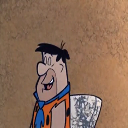

In [805]:
pil.fromarray(test_frame)